In [1]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,vstack

In [2]:
def get_dndzh(dat, rands, dweights=None, rweights=None, bins=10, return_edges=False):
    dh,_ = np.histogram(dat,weights=dweights,bins=bins)
    rh,bn = np.histogram(rands,weights=rweights,bins=bins)
    norm = sum(dh)/sum(rh)
    if return_edges: 
        return dh, rh, norm, bn
    else: 
        return dh, rh, norm

In [3]:
#!ls -l /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/

In [4]:
survey_dir = "/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/"

In [5]:
%%time
nran = 18
reg = 'NGC' #'SGC'
keep = ['RA','DEC','Z','WEIGHT','WEIGHT_FKP']

# get LRG 
lrg = fitsio.read(survey_dir+f"LRG_{reg}_clustering.dat.fits",columns=keep)
lrg_rands = [] 
for iran in range(nran):
    r = fitsio.read(survey_dir+f"LRG_{reg}_{iran}_clustering.ran.fits",columns=keep)
    lrg_rands.append(r)
lrg_rands = np.concatenate(lrg_rands)

# get ELG
elg = fitsio.read(survey_dir+f"ELG_LOPnotqso_{reg}_clustering.dat.fits",columns=keep)
elg_rands = [] 
for iran in range(nran):
    r = fitsio.read(survey_dir+f"ELG_LOPnotqso_{reg}_{iran}_clustering.ran.fits",columns=keep)
    elg_rands.append(r)
elg_rands = np.concatenate(elg_rands)

CPU times: user 27.3 s, sys: 30.3 s, total: 57.6 s
Wall time: 1min 2s


In [6]:
%%time
# parameters
bins = 10

#LRG
lrgwts = lrg['WEIGHT']*lrg['WEIGHT_FKP']
lrgwts_rands = lrg_rands['WEIGHT']*lrg_rands['WEIGHT_FKP']
lrgh, lrgh_rands, norm_lrgh = get_dndzh(lrg['Z'], lrg_rands['Z'], bins=bins)
lrghw, lrghw_rands, norm_lrghw = get_dndzh(lrg['Z'], lrg_rands['Z'], dweights=lrgwts, rweights=lrgwts_rands, bins=bins)

#ELG
elgwts = elg['WEIGHT']*elg['WEIGHT_FKP']
elgwts_rands = elg_rands['WEIGHT']*elg_rands['WEIGHT_FKP']
elgh, elgh_rands, norm_elgh = get_dndzh(elg['Z'], elg_rands['Z'], bins=bins)
elghw, elghw_rands, norm_elghw = get_dndzh(elg['Z'], elg_rands['Z'], dweights=elgwts, rweights=elgwts_rands, bins=bins)

# Full
full = np.concatenate([lrg,elg])

lrg_rands = Table(lrg_rands)
lrg_rands['NZ_NORM']  = np.full_like(lrg_rands['Z'],norm_lrgh)
lrg_rands['NZ_NORMW'] = np.full_like(lrg_rands['Z'],norm_lrghw)

elg_rands = Table(elg_rands)
elg_rands['NZ_NORM']  = np.full_like(elg_rands['Z'],norm_elgh)
elg_rands['NZ_NORMW'] = np.full_like(elg_rands['Z'],norm_elghw)

full_rands = vstack([lrg_rands,elg_rands])
fullwts = full['WEIGHT']*full['WEIGHT_FKP']
fullwts_rands = full_rands['WEIGHT']*full_rands['WEIGHT_FKP']*full_rands['NZ_NORMW']

CPU times: user 14.6 s, sys: 26.3 s, total: 40.8 s
Wall time: 40.8 s


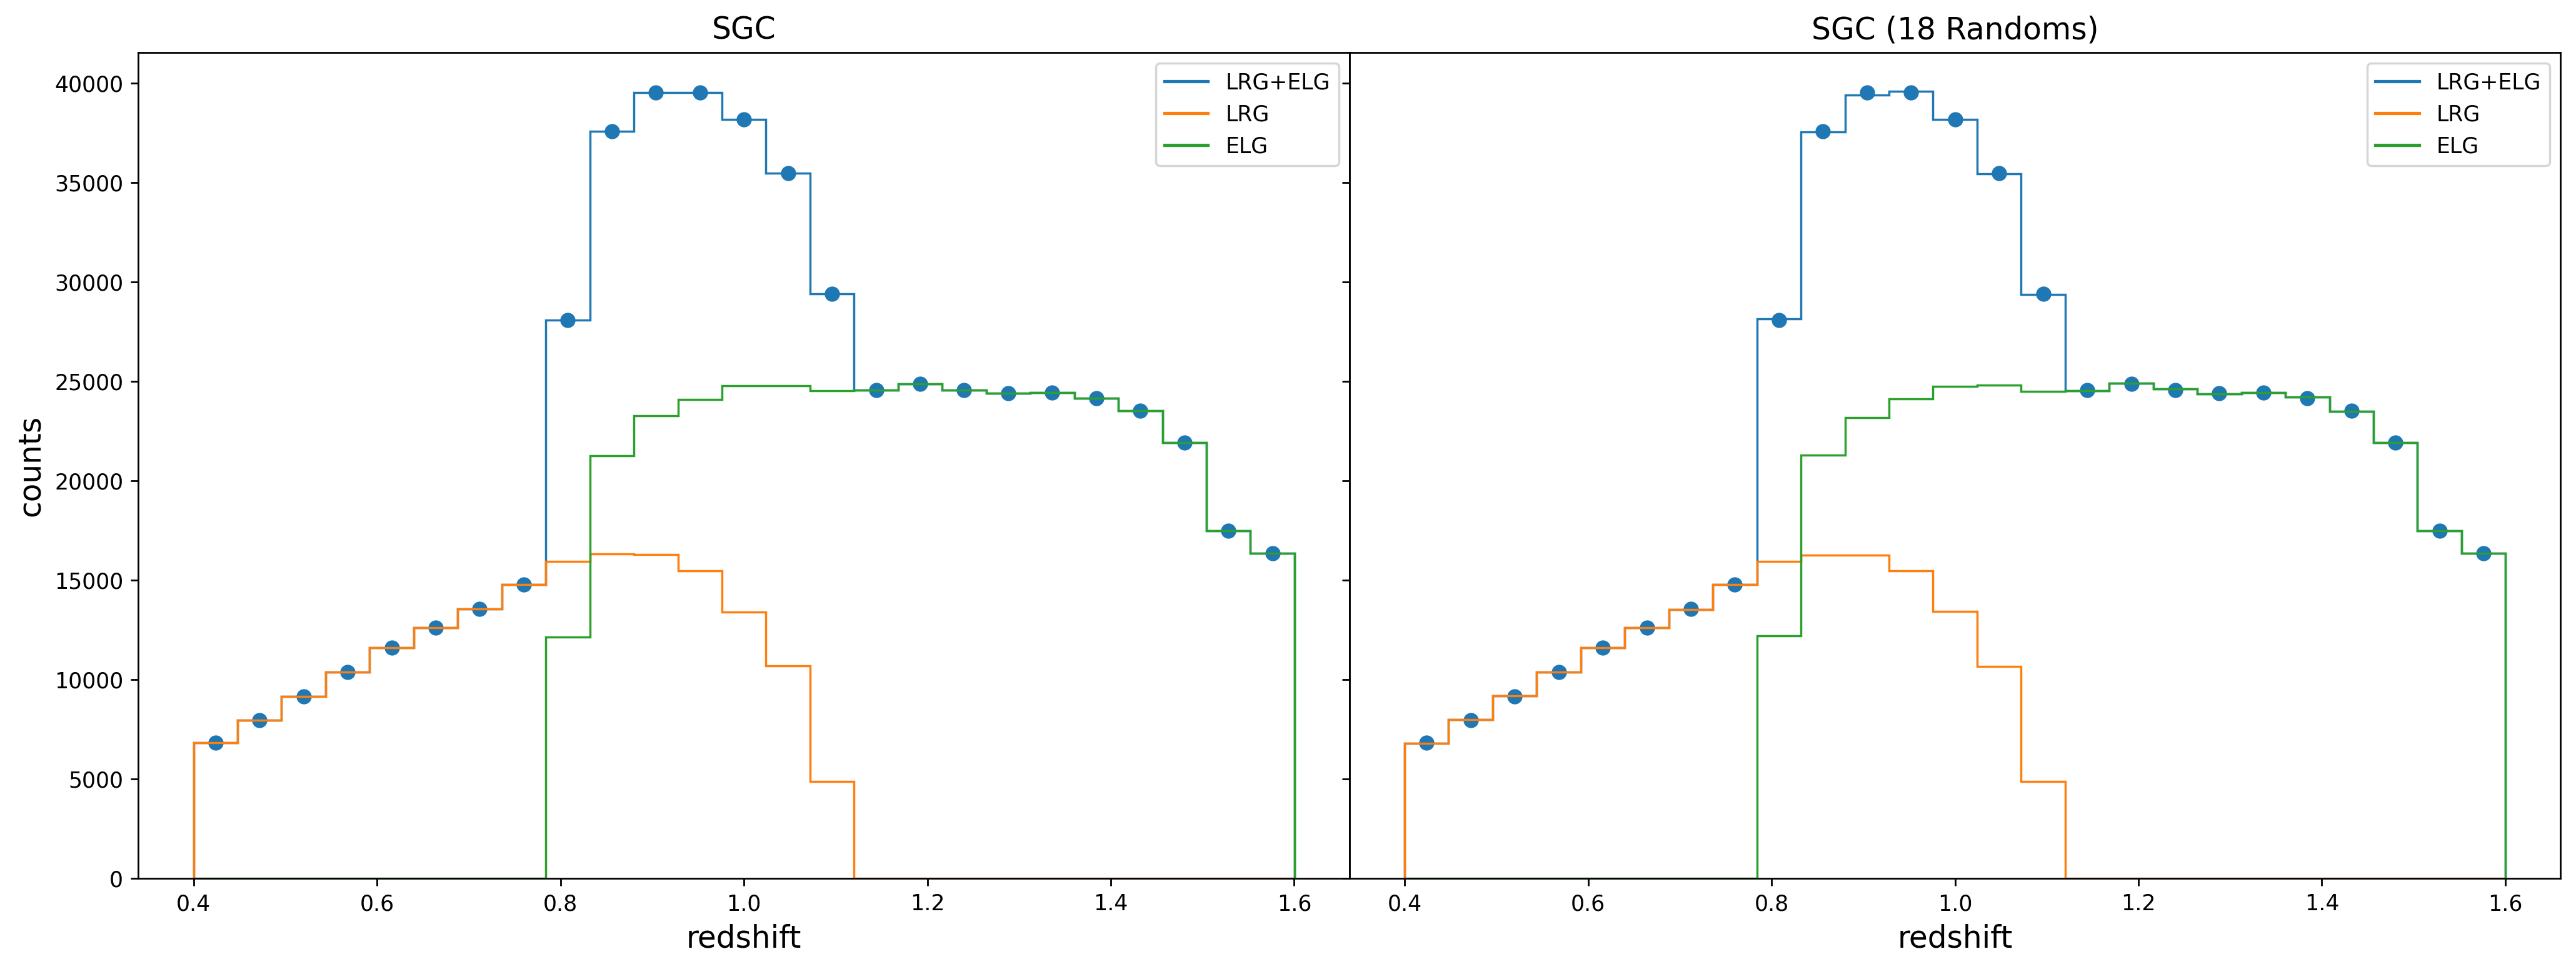

In [12]:
bins = 25
fig,lax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey='row',figsize=(20,7),dpi=250)
fig.subplots_adjust(wspace=0)
ax = lax.flatten()

#
fullhw,fullhw_rands,_,bn = get_dndzh(full['Z'], full_rands['Z'], dweights=fullwts, rweights=fullwts_rands, bins=bins, return_edges=True)
bc = (bn[:-1] + bn[1:]) / 2
kws = dict(bins=bn,histtype='step')

# plot from data
ax[0].hist(bc,len(fullhw),weights=fullhw,range=(bn[0],bn[-1]),histtype='step',color=f'C{0}')
ax[0].hist(lrg['Z'],weights=lrgwts,color=f'C{1}',**kws)
ax[0].hist(elg['Z'],weights=elgwts,color=f'C{2}',**kws)
ax[0].scatter(bc,fullhw,color=f'C{0}')

ax[0].set_title(f'{reg}',fontsize=14)
ax[0].set_xlabel('redshift',fontsize=14)
ax[0].set_ylabel('counts',fontsize=14)
tlabels = ['LRG+ELG','LRG','ELG']
for ic,t in enumerate(tlabels):
    ax[0].plot([],[],c=f"C{ic}",label=t)
ax[0].legend()

# plot randoms  
ax[1].hist(bc,len(fullhw_rands),weights=fullhw_rands,range=(bn[0],bn[-1]),histtype='step',color=f'C{0}')
ax[1].hist(lrg_rands['Z'],weights=lrgwts_rands*norm_lrghw,color=f'C{1}',**kws)
ax[1].hist(elg_rands['Z'],weights=elgwts_rands*norm_elghw,color=f'C{2}',**kws)
ax[1].scatter(bc,fullhw,color=f'C{0}')

ax[1].set_title(f'{reg} ({nran} Randoms)',fontsize=14)
ax[1].set_xlabel('redshift',fontsize=14)
tlabels = ['LRG+ELG','LRG','ELG']
for ic,t in enumerate(tlabels):
    ax[1].plot([],[],c=f"C{ic}",label=t)
ax[1].legend()
plt.savefig(f"{reg}_dndz.pdf")
plt.show()

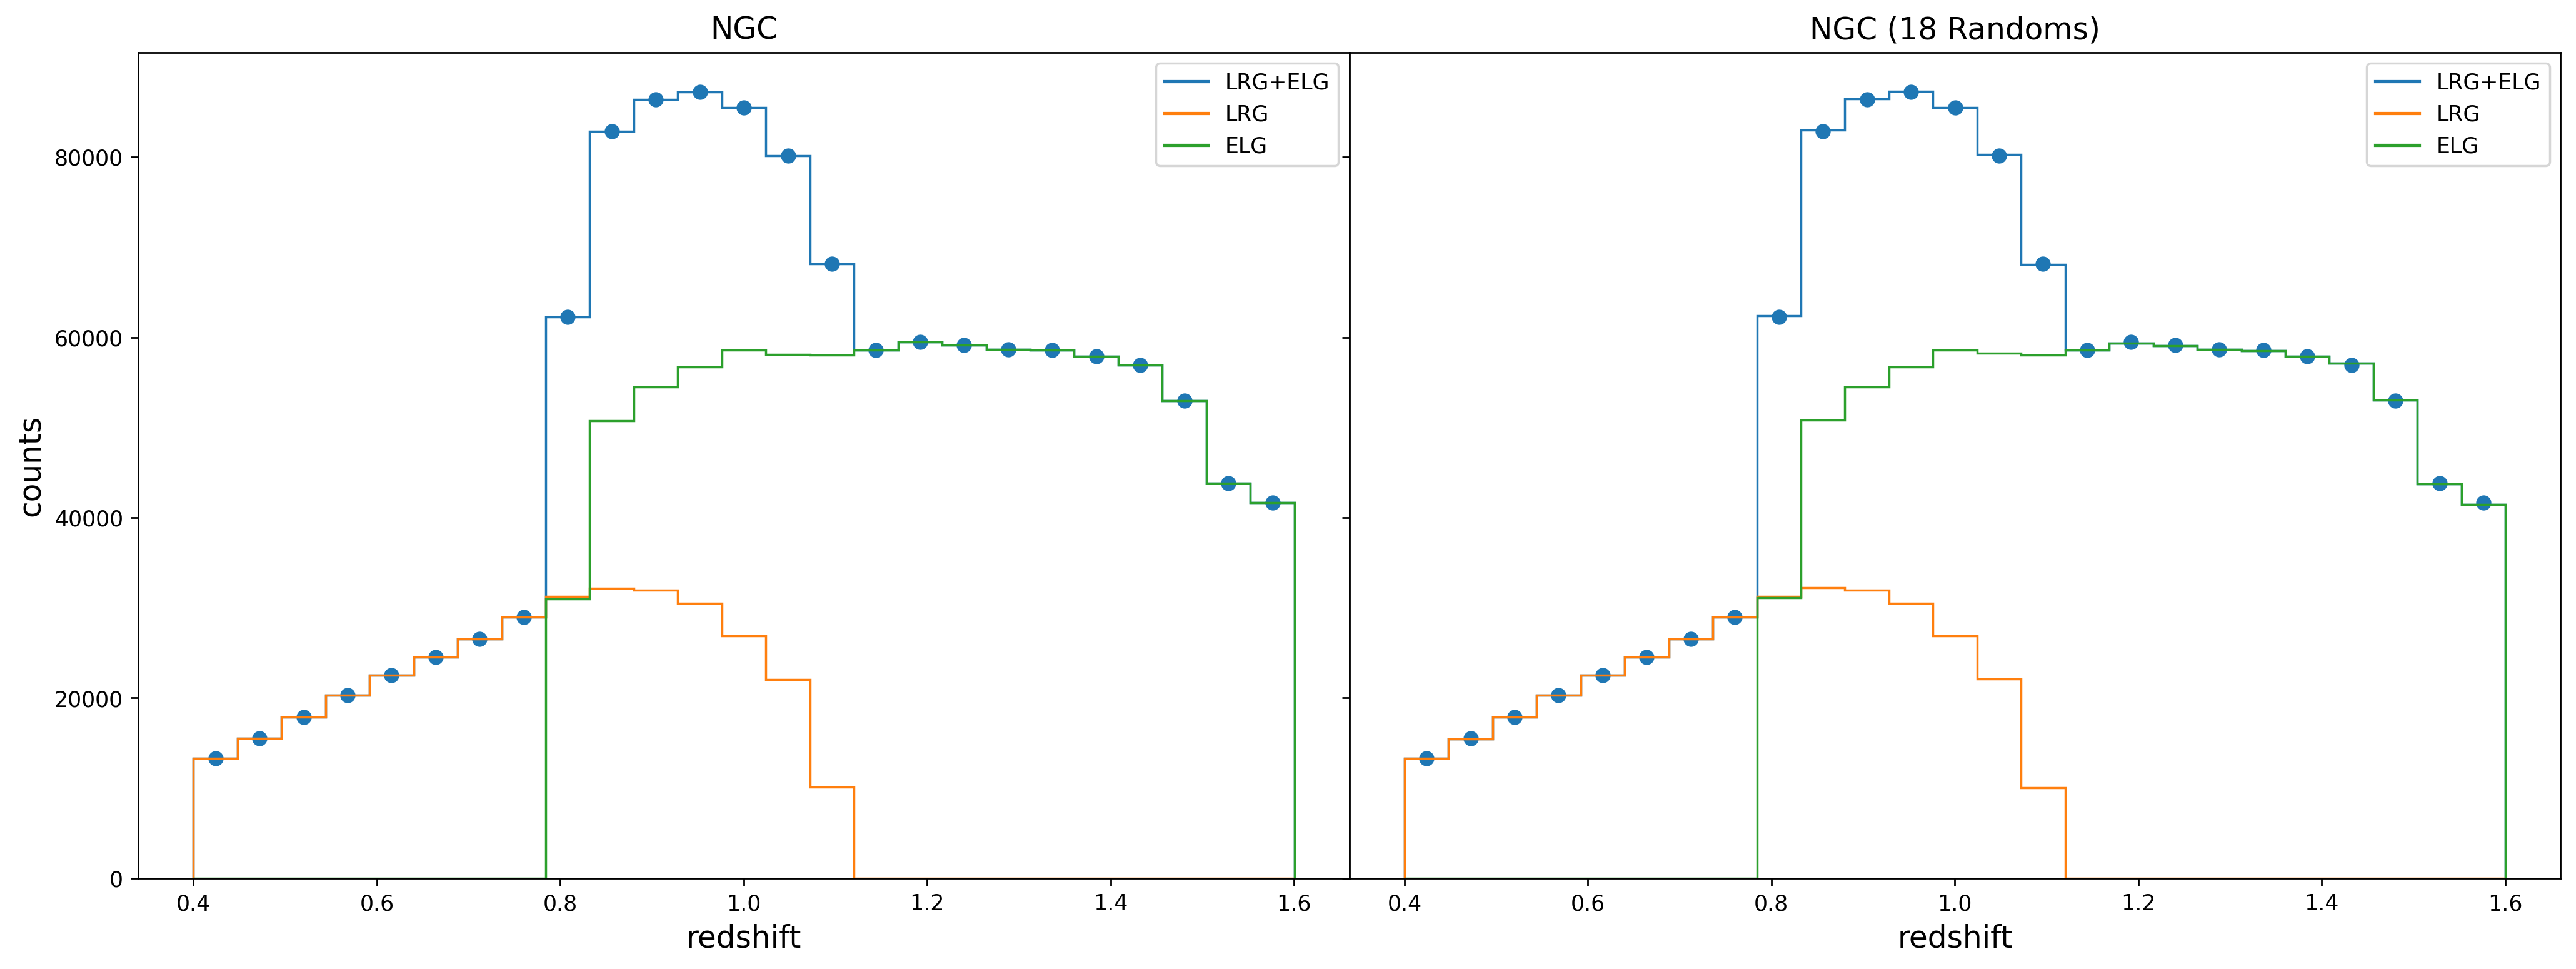

In [7]:
bins = 25
fig,lax = plt.subplots(ncols=2,nrows=1,sharex=False,sharey='row',figsize=(20,7),dpi=250)
fig.subplots_adjust(wspace=0)
ax = lax.flatten()

#
fullhw,fullhw_rands,_,bn = get_dndzh(full['Z'], full_rands['Z'], dweights=fullwts, rweights=fullwts_rands, bins=bins, return_edges=True)
bc = (bn[:-1] + bn[1:]) / 2
kws = dict(bins=bn,histtype='step')

# plot from data
ax[0].hist(bc,len(fullhw),weights=fullhw,range=(bn[0],bn[-1]),histtype='step',color=f'C{0}')
ax[0].hist(lrg['Z'],weights=lrgwts,color=f'C{1}',**kws)
ax[0].hist(elg['Z'],weights=elgwts,color=f'C{2}',**kws)
ax[0].scatter(bc,fullhw,color=f'C{0}')

ax[0].set_title(f'{reg}',fontsize=14)
ax[0].set_xlabel('redshift',fontsize=14)
ax[0].set_ylabel('counts',fontsize=14)
tlabels = ['LRG+ELG','LRG','ELG']
for ic,t in enumerate(tlabels):
    ax[0].plot([],[],c=f"C{ic}",label=t)
ax[0].legend()

# plot randoms  
ax[1].hist(bc,len(fullhw_rands),weights=fullhw_rands,range=(bn[0],bn[-1]),histtype='step',color=f'C{0}')
ax[1].hist(lrg_rands['Z'],weights=lrgwts_rands*norm_lrghw,color=f'C{1}',**kws)
ax[1].hist(elg_rands['Z'],weights=elgwts_rands*norm_elghw,color=f'C{2}',**kws)
ax[1].scatter(bc,fullhw,color=f'C{0}')

ax[1].set_title(f'{reg} ({nran} Randoms)',fontsize=14)
ax[1].set_xlabel('redshift',fontsize=14)
tlabels = ['LRG+ELG','LRG','ELG']
for ic,t in enumerate(tlabels):
    ax[1].plot([],[],c=f"C{ic}",label=t)
ax[1].legend()
plt.savefig(f"{reg}_dndz.pdf")
plt.show()

# Other stuff

In [8]:
def get_hist(dat, weights=None, bins=10, plot=False, ax=None, marker=None, return_edges=False, **kwargs):
    h,bn = np.histogram(dat,weights=weights,bins=bins)
    bc = (bn[:-1] + bn[1:]) / 2
    if plot: 
        if ax is None:
            plt.hist(dat,bins=bn,weights=weights,histtype='step',**kwargs)
            plt.plot(bc,h,marker=marker,markersize=5,**kwargs)
        else:
            ax.hist(dat,bins=bn,weights=weights,histtype='step',**kwargs)
            ax.plot(bc,h,marker=marker,markersize=5,**kwargs)

    if return_edges:
        return h,bn
    else:
        return h,bc

def rel_dndz(dat, rands, dweights=None, rweights=None, bins=10):
    dh,_ = np.histogram(dat,weights=dweights,bins=bins)
    rh,bn = np.histogram(rands,weights=rweights,bins=bins)
    bc = (bn[:-1] + bn[1:]) / 2
    norm = sum(rh)/sum(dh)
    sv = dh/rh*norm
    return bc, sv

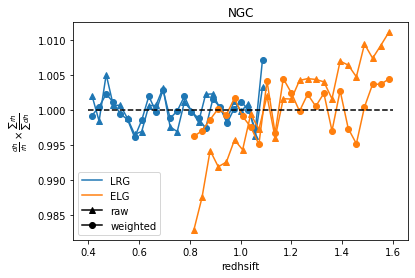

In [10]:
# LRGs
bc,sv = rel_dndz(lrg['Z'],lrg_rands['Z'],bins=bins)
plt.plot(bc,sv,c=f'C{0}',marker='^')

bc,sv = rel_dndz(lrg['Z'],lrg_rands['Z'], dweights=lrgwts, rweights=lrgwts_rands, bins=bins)
plt.plot(bc,sv,c=f'C{0}',marker='o')

# ELGs
bc,sv = rel_dndz(elg['Z'],elg_rands['Z'],bins=bins)
plt.plot(bc,sv,c=f'C{1}',marker='^')

bc,sv = rel_dndz(elg['Z'],elg_rands['Z'], dweights=elgwts, rweights=elgwts_rands, bins=bins)
plt.plot(bc,sv,c=f'C{1}',marker='o')

# plot decoration
tlabels = ['LRG','ELG']
for ic,tracer in enumerate(tlabels):
    plt.plot([],[],c=f"C{ic}",label=tracer)
mlabels = ['raw','weighted']
for i,marker in enumerate(['^','o']):
    plt.plot([],[],marker=marker,c='k',label=mlabels[i])
plt.title(reg)
plt.legend()
plt.xlabel('redhsift')
plt.ylabel(r'$\frac{dh}{rh} \times \frac{\sum{rh}}{\sum{dh}}$')

plt.hlines(1,xmin=0.4,xmax=1.6, color='k',linestyle='--')
plt.show()